# Kannada MNIST Neural Network Challenge

Kaggle competition link: https://www.kaggle.com/c/Kannada-MNIST

#### Kaggle Competition Description

The goal of this competition is to provide a simple extension to the classic MNIST competition we're all familiar with. Instead of using Arabic numerals, it uses a recently-released dataset of Kannada digits.

Kannada is a language spoken predominantly by people of Karnataka in southwestern India. The language has roughly 45 million native speakers and is written using the Kannada script. Wikipedia

This competition uses the same format as the MNIST competition in terms of how the data is structured, but it's different in that it is a synchronous re-run Kernels competition. You write your code in a Kaggle Notebook, and when you submit the results, your code is scored on both the public test set, as well as a private (unseen) test set.

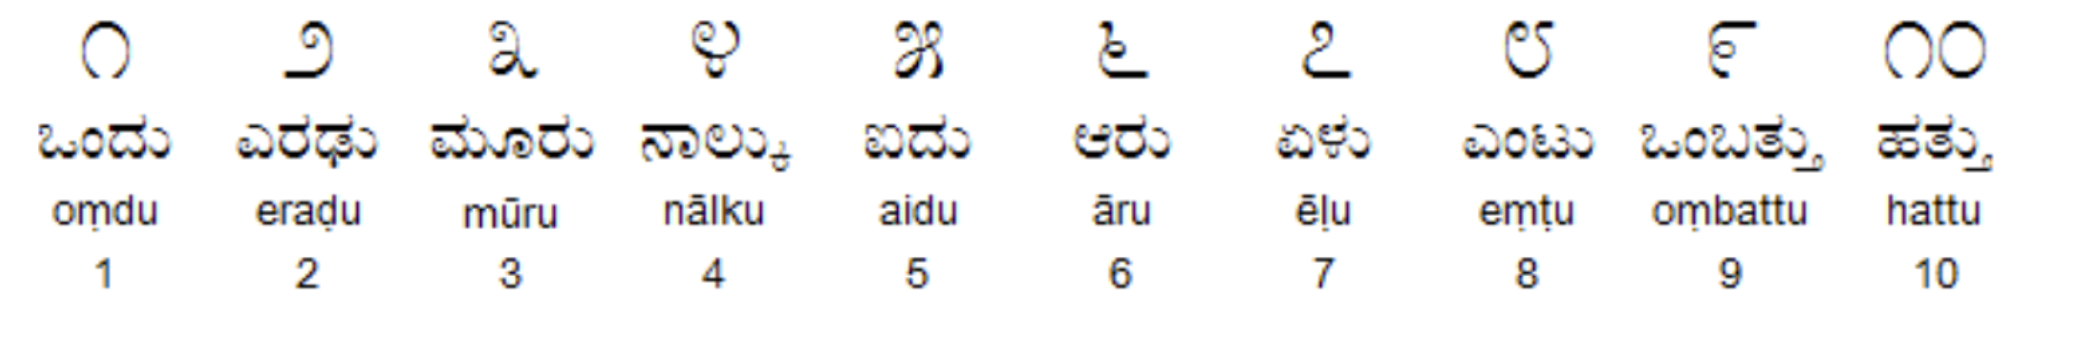

This challenge required me to make my first neural network. There was a steep learning curve in the beginning for me, but I learned a lot along the way.

The following notebook helped guide me along the way:

https://www.kaggle.com/sauravjoshi23/kannada-mnist-comparing-accuracy-of-various-models

For this notebook specifically, I will be getting straight to the point of building the neural network and not presenting any eda or data visualizations. For visualizations, please visit my previous notebook in this challenge where I used a random forest classifier with PCA.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten
from keras.optimizers import Adam ,RMSprop
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras import  backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.preprocessing import image
from keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras import layers, callbacks
from keras.layers import BatchNormalization

In [2]:
train = pd.read_csv('train.csv')
print(train.shape)
train.head()

(60000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
test = pd.read_csv('test.csv')

print(test.shape)
test.head()

(5000, 785)


,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Split features and test

In [4]:
X_train = (train.iloc[:,1:].values).astype('float32')
y_train = train.iloc[:,0].values.astype('int32')
X_test = (test.iloc[:,1:].values).astype('float32')

In [5]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Transforming data to be 4 dimensional

In [6]:
X_train = X_train.reshape(X_train.shape[0],28,28,1) 
X_test = X_test.reshape(X_test.shape[0],28,28,1) 

print(X_train.shape) 
print(X_test.shape)

(60000, 28, 28, 1)
(5000, 28, 28, 1)


## Standardizing the data

In [7]:
meanpx = X_train.mean().astype(np.float32)
stdpx = X_train.std().astype(np.float32)

def standardize(x):
    return (x-meanpx)/stdpx

In [8]:
y_train = to_categorical(y_train)
num_classes = y_train.shape[1]
num_classes

10

## CNN

In [9]:
gen = image.ImageDataGenerator()

In [10]:
X = X_train
y = y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches=gen.flow(X_val, y_val, batch_size=64)

In [11]:
def cnn_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Convolution2D(32,(3,3), activation='relu'),
        Dropout(0.3),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        Dropout(0.3),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [12]:
model= cnn_model()
model.optimizer.lr=0.01

In [13]:
history=model.fit_generator(generator=batches, steps_per_epoch=X_train.shape[0]//64, epochs=20, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
843/843 [==============================] - 35s 42ms/step - loss: 0.3858 - accuracy: 0.8795 - val_loss: 0.2407 - val_accuracy: 0.9400
Epoch 2/20
843/843 [==============================] - 37s 44ms/step - loss: 0.2178 - accuracy: 0.9277
Epoch 3/20
843/843 [==============================] - 35s 42ms/step - loss: 0.2104 - accuracy: 0.9310
Epoch 4/20
843/843 [==============================] - 40s 47ms/step - loss: 0.1958 - accuracy: 0.9369
Epoch 5/20
843/843 [==============================] - 38s 46ms/step - loss: 0.1919 - accuracy: 0.9378
Epoch 6/20
843/843 [==============================] - 40s 47ms/step - loss: 0.1842 - accuracy: 0.9412
Epoch 7/20
843/843 [==============================] - 39s 46ms/step - loss: 0.1781 - accuracy: 0.9432
Epoch 8/20
843/843 [==============================] - 40s 47ms/step - loss: 0.1745 - accuracy: 0.9433
Epoch 9/20
843/843 [==============================] - 39s 47ms/ste

15 Epochs took quite a bit of time, let's add in early stopping to save some time

In [14]:
#with callback
early_stopping = callbacks.EarlyStopping(
    monitor='loss', min_delta=0.001, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

history=model.fit_generator(generator=batches, steps_per_epoch=X_train.shape[0]//64, epochs=20, 
                    validation_data=val_batches, validation_steps=val_batches.n, callbacks=[early_stopping])

Epoch 1/20
843/843 [==============================] - 47s 56ms/step - loss: 0.1620 - accuracy: 0.9495 - val_loss: 0.3592 - val_accuracy: 0.8727
Epoch 2/20
843/843 [==============================] - 45s 53ms/step - loss: 0.1581 - accuracy: 0.9498
Epoch 3/20
843/843 [==============================] - 40s 47ms/step - loss: 0.1671 - accuracy: 0.9479
Epoch 4/20
843/843 [==============================] - 40s 47ms/step - loss: 0.1680 - accuracy: 0.9468
Epoch 5/20
843/843 [==============================] - 40s 47ms/step - loss: 0.1623 - accuracy: 0.9479
Epoch 6/20
843/843 [==============================] - 42s 49ms/step - loss: 0.1622 - accuracy: 0.9479
Epoch 7/20
843/843 [==============================] - 41s 49ms/step - loss: 0.1654 - accuracy: 0.9477


We can see here that early stopping was called and we only had to run 7 epochs before we started to see a decrease in accuracy. This callback helps us to not only save time, but more importantly prevent overfitting the data.

## Batch Normalization

In [15]:
def cnn_model_batch():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Convolution2D(32,(3,3), activation='relu'),
        Dropout(0.3),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        Dropout(0.3),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [16]:
model= cnn_model_batch()
model.optimizer.lr=0.01

In [17]:
history=model.fit_generator(generator=batches, steps_per_epoch=X_train.shape[0]//64, epochs=20, 
                    validation_data=val_batches, validation_steps=val_batches.n, callbacks=[early_stopping])

Epoch 1/20
843/843 [==============================] - 84s 100ms/step - loss: 0.2635 - accuracy: 0.9527 - val_loss: 0.1411 - val_accuracy: 0.9553
Epoch 2/20
843/843 [==============================] - 85s 101ms/step - loss: 0.0572 - accuracy: 0.9831
Epoch 3/20
843/843 [==============================] - 89s 106ms/step - loss: 0.0425 - accuracy: 0.9869
Epoch 4/20
843/843 [==============================] - 91s 108ms/step - loss: 0.0315 - accuracy: 0.9905
Epoch 5/20
843/843 [==============================] - 90s 107ms/step - loss: 0.0317 - accuracy: 0.9906
Epoch 6/20
843/843 [==============================] - 91s 109ms/step - loss: 0.0405 - accuracy: 0.9892
Epoch 7/20
843/843 [==============================] - 92s 109ms/step - loss: 0.0389 - accuracy: 0.9897
Epoch 8/20
843/843 [==============================] - 91s 108ms/step - loss: 0.0329 - accuracy: 0.9912
Epoch 9/20
843/843 [==============================] - 86s 102ms/step - loss: 0.0379 - accuracy: 0.9908


## Kaggle Submission

In [18]:
sample = pd.read_csv('sample_submission.csv')

In [19]:
sample["label"] = np.argmax(model.predict(X_test), 1)
sample.head()
# submissions.to_csv("submission.csv", index=False, header=True)

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7


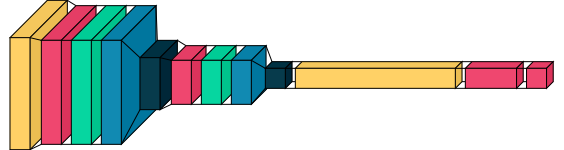

In [20]:
import visualkeras
visualkeras.layered_view(model).show()
visualkeras.layered_view(model, to_file='output.png').show()

visualkeras.layered_view(model)